In [1]:
import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import copy
import time
from itertools import repeat

from IPython.display import clear_output
import h5py

In [2]:
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
device

'cpu'

In [3]:
import tensorly as tl
import tensorly.decomposition
import tensorly.random

In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Darwin-19.6.0-x86_64-i386-64bit
Python 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
NumPy 1.19.4
SciPy 1.5.4
TensorLy 0.5.0
PyTorch 1.7.0


In [5]:
tl.set_backend('pytorch')

In [6]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)

In [13]:
filepath = '/Users/wingillis/gdrive/datta/for_Win/Sxx_allPixels.h5'

In [14]:
with h5py.File(filepath, 'r') as h5f:
  shape = h5f['data'].shape

In [7]:
### Make dataset objects
class make_batchSlices_dataObj(Dataset):
    def __init__(self, filepath):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = h5py.File(filepath, 'r')
    def __len__(self):
        return len(self.tensor_full['data'])
    def __getitem__(self, idx):
        tensor_slice = torch.tensor(self.tensor_full['data'][idx], dtype=torch.float32)
        return tensor_slice, idx
    def __del__(self):
        self.tensor_full.close()

In [8]:
##Define Function and class to be used

class NTF(nn.Module): ## Model
    def __init__(self, shapes, rank):
        super(NTF, self).__init__()
        for i, (s, r) in enumerate(zip(shapes, repeat(rank)), start=1):
          setattr(self, 'factors{}'.format(i), nn.Parameter(torch.tensor(rng.random_sample((s, r)), dtype=torch.float32)))
        self.weights = nn.Parameter(torch.tensor(np.ones(rank), dtype=torch.float32), requires_grad=True)
        
    def forward(self, idx, update='H'):
        tmp = [self.factors1[idx],
               self.factors2,
               self.factors3,
               self.factors4]
        
        if update == 'H':
          inputs = (self.weights.detach(), tmp)
        elif update == 'W':
          inputs = (self.weights, [x.detach() for x in tmp])
        
        reconstruction = F.relu(tl.cp_tensor.cp_to_tensor(inputs))
        return reconstruction


class NonNegativeClipper(object):
    def __init__(self, eps=1e-8):
        self.pos_constraint = nn.Threshold(0, eps)

    def __call__(self, module):
        # filter the variables to get the ones you want
        for param in module.parameters():
            param.data = self.pos_constraint(param.data)

Start training on Task 1...


In [11]:
batch_size = 512

data = DataLoader(make_batchSlices_dataObj(filepath), batch_size=batch_size,
                  drop_last=False, shuffle=True)

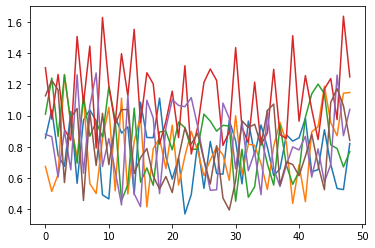

KeyboardInterrupt: 

In [17]:
# goal_tensor = tensor
rank = 6
ntf_obj = NTF(shape, rank).to(device)
loss_rolling = [] #collect loss

n_epoch = 10000
lr = 0.0075
display_every = 2  # iterations
clip_freq = 1  # iterations

# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
optimizer = torch.optim.Adam(ntf_obj.parameters(), lr=lr, weight_decay=0.05)

clipper = NonNegativeClipper(frequency=1)

for epoch in range(n_epoch):
    for i, (Y, idx) in enumerate(data):
        msk = np.isin(np.arange(shape[0]), idx)
        Y = Y.to(device)
        
        start = time.time()
        optimizer.zero_grad() # need to clear the old gradients
        _weights = ntf_obj.factors1.detach()
        Y_hat = ntf_obj(idx, update='H')
        loss = tl.norm(Y - Y_hat, 2)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          ntf_obj.factors1[msk] = _weights[msk]

        optimizer.zero_grad() # need to clear the old gradients
        Y_ = ntf_obj(idx, update='W')
        loss = tl.norm(Y - Y_hat, 2)
        loss.backward()
        optimizer.step()

        if i % clip_freq == 0:
            ntf_obj.apply(clipper)

        if i % display_every == 0:
            clear_output()
            loss_rolling.append(loss.item() / len(idx))
            print("Epoch {} -- Time per iter: {:0.3f}s -- loss: {:0.3f}".format(epoch, time.time() - start, loss.item() / len(idx)), end='\r')
            plt.plot(ntf_obj.factors3.detach())
            plt.show()

print('Learning curve for Task 1')

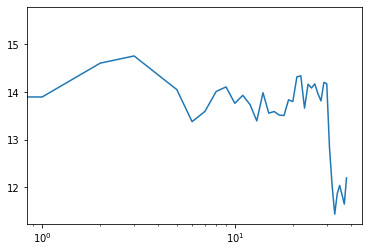

In [18]:
plt.plot(loss_rolling)
plt.xscale('log')

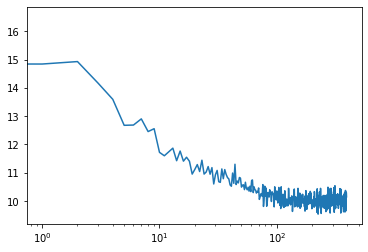

In [87]:
plt.plot(loss_rolling)
plt.xscale('log')

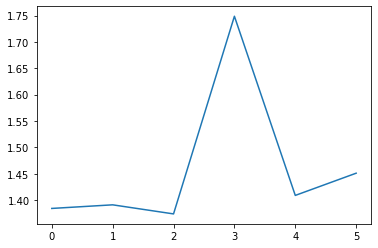

In [19]:
plt.plot(ntf_obj.weights.detach())

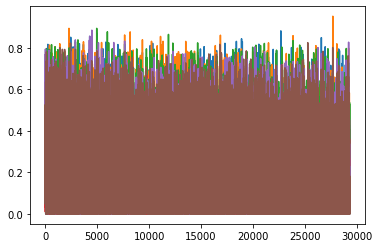

In [20]:
plt.plot(ntf_obj.factors1.detach())

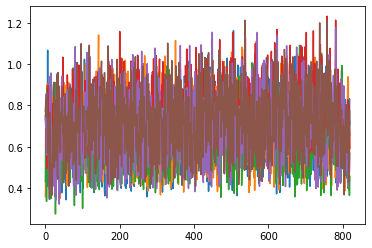

In [21]:
plt.plot(ntf_obj.factors2.detach())

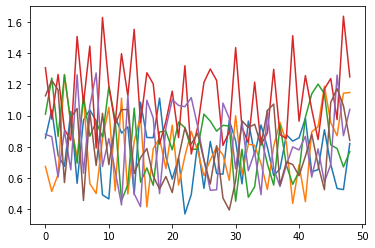

In [22]:
plt.plot(ntf_obj.factors3.detach())

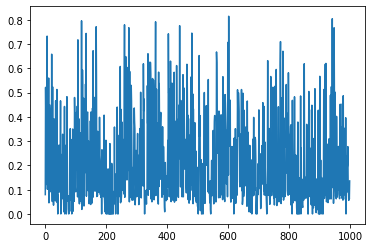

In [24]:
plt.plot(ntf_obj.factors1.detach()[:1000, 2])

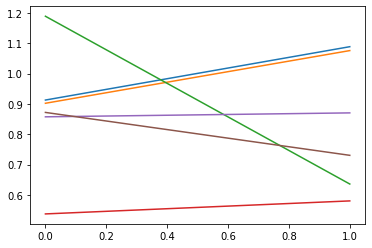

In [25]:
plt.plot(ntf_obj.factors4.detach())